In [2]:
import os,sys, re
from importlib import reload
import numpy as np
import pandas as pd
from Bio.Seq import reverse_complement
#import torch
print(os.getpid())
sys.path.append(r"/lab/weissman_imaging/puzheng/Softwares")


from ChromAn.src.library_tools.primers import load_fasta_to_DataFrame
#import MERFISH_probe_design.probe_design.OTTable_dict as ot

3968997


In [3]:
from ChromAn.src.file_io.data_organization import Color_Usage, search_fovs_in_folders, color_usage_kwds

In [4]:
import ChromAn
reload(ChromAn.src.file_io.data_organization)
from ChromAn.src.file_io.data_organization import Data_Organization, search_fovs_in_folders
from ChromAn.src.file_io.dax_process import DaxProcesser
from ChromAn.src.visual_tools.interactive import imshow_mark_3d

In [5]:
!ls /lab/weissman_imaging/puzheng/4T1Tumor/

20230622-4T1tumor_primary_F133section2		20231222-4T1tumor_F170_MF4
20230625-4T1cell_c2				20231226-MF4DNA_4T1preEditTop8
20230821-F133section18_PFAfix_dapi-mcherry	20240108-MF4_F171-4
20230928-4T1tumor_F170section4_0927MF2-mCherry	20240109-IF_F170


In [6]:
# where the original data saves
data_home =  r"/lab/weissman_imaging/puzheng"
data_folder = os.path.join(data_home, '4T1Tumor', '20240108-MF4_F171-4')

experiment_date = os.path.basename(data_folder).split('-')[0]
print(experiment_date)
# Color usage file marks the organization of imaging files
color_usage_filename = os.path.join(data_folder, 'Analysis', 'color_usage.csv')

20240108


In [7]:
os.listdir(data_folder)

['H0M1',
 'H1M2',
 'H2M3',
 'H3M4',
 'H4M5',
 'H5M6',
 'H6M7',
 'H7M8',
 'H8M9',
 'H9M2',
 'Segmentation',
 'Analysis']

In [8]:
# visualize some images:
folders, fovs = search_fovs_in_folders(data_folder)
sel_fov = 45

test_ref_filename = os.path.join(folders[0], fovs[sel_fov])
test_filename = os.path.join(folders[1], fovs[sel_fov])
# load ref
daxp_ref = DaxProcesser(test_ref_filename)
daxp_ref._load_image()
#daxp_ref._corr_hot_pixels()
# load
daxp = DaxProcesser(test_filename)
daxp._load_image()
#daxp._corr_hot_pixels()
daxp._calculate_drift(RefImage=daxp_ref.im_477, FiducialChannel='477')

- searching in folder: /lab/weissman_imaging/puzheng/4T1Tumor/20240108-MF4_F171-4
-- 10 folders, 142 fovs detected.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240108-MF4_F171-4/H0M1/Conv_zscan_045.dax
- New save file: /lab/weissman_imaging/puzheng/4T1Tumor/20240108-MF4_F171-4/H0M1/Conv_zscan_045_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['748', '637', '477', '405'] in 2.366s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240108-MF4_F171-4/H1M2/Conv_zscan_045.dax
- New save file: /lab/weissman_imaging/puzheng/4T1Tumor/20240108-MF4_F171-4/H1M2/Conv_zscan_045_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['748', '637', '477'] in 1.930s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.01

(array([-0.01      ,  1.16666667, -0.83      ]), 1)

### Quickly visualize bead image to find bead-localizing z-frame

<IPython.core.display.Javascript object>


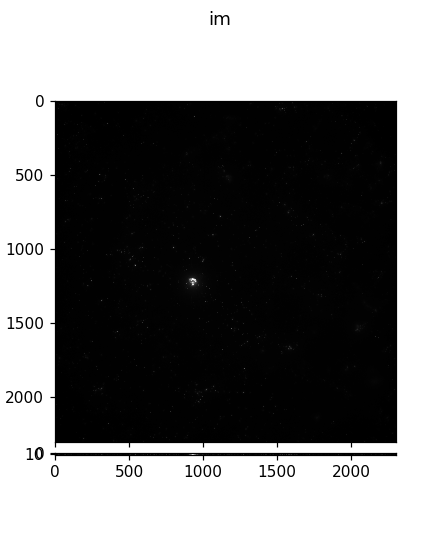

In [9]:
%matplotlib notebook
imshow_mark_3d([daxp.im_477, daxp_ref.im_477], image_names=['im', 'ref'])

<IPython.core.display.Javascript object>


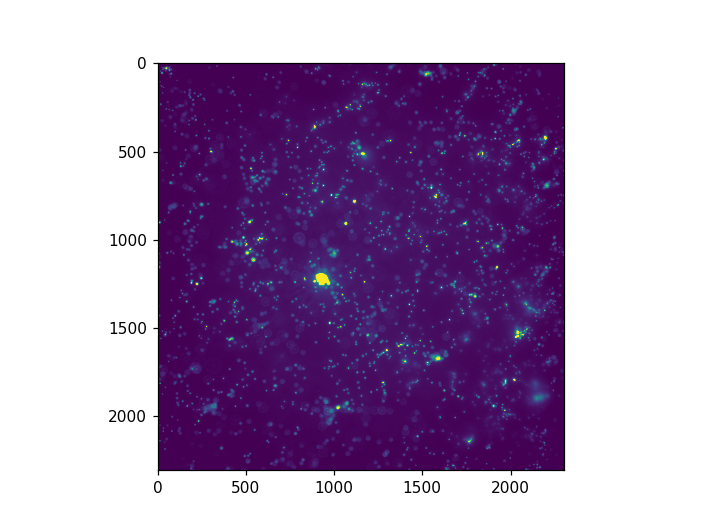

In [15]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(daxp_ref.im_477[12], vmin=500, vmax=5000)

<IPython.core.display.Javascript object>


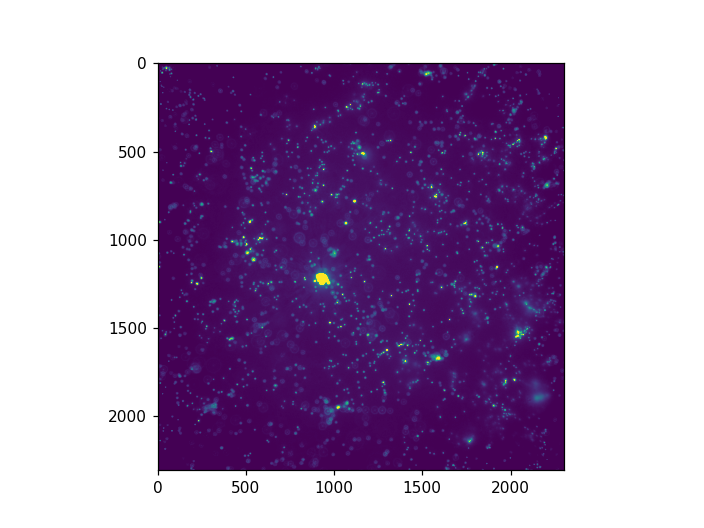

In [12]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(daxp.im_477[12], vmin=500, vmax=5000)

In [16]:
ref_Zstep = 12 # start from 0, manually check several images

In [18]:
# Load readout names:
library_folder = r'/lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF4_4T1Primary16bit'
readout_filename = os.path.join(library_folder, 'readouts.csv')

if os.path.exists(readout_filename):
    readouts = pd.read_csv(readout_filename) 
else:
    # generate readout_file
    import MERFISH_probe_design.IO.file_io as fio
    merfish_bits_file = os.path.join(r'/lab/solexa_weissman/puzheng/References/Readouts', 'MERFISH_readouts.fasta')
    merfish_bits = fio.load_fasta_into_df(merfish_bits_file)
    # first 22 bits are for this library:
    readouts = {'Name':[_id.split('-')[-1] for _id in merfish_bits.loc[:, 'id']], 
                'Sequence':merfish_bits.loc[:, 'sequence']}
    readouts = pd.DataFrame(readouts)
    # save this readout
    readouts.to_csv(readout_filename, index=None)
# select names
readout_names = list(readouts['Name'])
print(len(readout_names))

16


In [19]:
# Generate data organization
data_organization_filename = f'../../merlin_parameters/dataorganization/{experiment_date}-MF4_{len(readout_names)}bit.csv'
_do = Data_Organization(data_organization_filename,)
if _do.is_empty():
    # create
    _do.create_from_colorUsage(color_usage_filename, data_folder,ref_Zstep, readout_names=readout_names)
    # save
    _do.save_to_file(overwrite=True)

- load color_usage from file: /lab/weissman_imaging/puzheng/4T1Tumor/20240108-MF4_F171-4/Analysis/color_usage.csv
- searching in folder: /lab/weissman_imaging/puzheng/4T1Tumor/20240108-MF4_F171-4
-- 10 folders, 142 fovs detected.
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
- 16 MERFISH rows appended.
- PolyT row appended.
- DAPI row appended.
Saving data_organization into file: ../../merlin_parameters/dataorganization/20240108-MF4_16bit.csv.


In [20]:
ref_image_type = '748_637_477_405_s13' # ref 58 / 65
polyt_image_type = '748_637_477_s13'
image_type = '748_637_477_s13' # ref 36/39

In [21]:
_do

,channelName,readoutName,imageType,imageRegExp,bitNumber,imagingRound,color,frame,zPos,fiducialImageType,fiducialRegExp,fiducialImagingRound,fiducialFrame,fiducialColor
0,bit1,b1-RS0015,748_637_477_405_s13,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,1,0,748,[0 4 8 12 16 20 24 28 32 36 40 44 48],[-6.5 -5.5 -4.5 -3.5 -2.5 -1.5 -0.5 0.5 1.5 2....,748_637_477_405_s13,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,0,50,477
1,bit2,b2-RS0083,748_637_477_405_s13,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,2,0,637,[1 5 9 13 17 21 25 29 33 37 41 45 49],[-6.5 -5.5 -4.5 -3.5 -2.5 -1.5 -0.5 0.5 1.5 2....,748_637_477_405_s13,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,0,50,477
2,bit3,b3-RS0095,748_637_477_s13,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,3,9,748,[0 3 6 9 12 15 18 21 24 27 30 33 36],[-6.5 -5.5 -4.5 -3.5 -2.5 -1.5 -0.5 0.5 1.5 2....,748_637_477_s13,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,9,38,477
3,bit4,b4-RS0109,748_637_477_s13,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,4,9,637,[1 4 7 10 13 16 19 22 25 28 31 34 37],[-6.5 -5.5 -4.5 -3.5 -2.5 -1.5 -0.5 0.5 1.5 2....,748_637_477_s13,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,9,38,477
4,bit5,b5-RS0175,748_637_477_s13,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,5,1,748,[0 3 6 9 12 15 18 21 24 27 30 33 36],[-6.5 -5.5 -4.5 -3.5 -2.5 -1.5 -0.5 0.5 1.5 2....,748_637_477_s13,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,1,38,477
5,bit6,b6-RS0237,748_637_477_s13,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,6,1,637,[1 4 7 10 13 16 19 22 25 28 31 34 37],[-6.5 -5.5 -4.5 -3.5 -2.5 -1.5 -0.5 0.5 1.5 2....,748_637_477_s13,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,1,38,477
6,bit7,b7-RS0247,748_637_477_s13,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,7,2,748,[0 3 6 9 12 15 18 21 24 27 30 33 36],[-6.5 -5.5 -4.5 -3.5 -2.5 -1.5 -0.5 0.5 1.5 2....,748_637_477_s13,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,2,38,477
7,bit8,b10-RS0332,748_637_477_s13,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,8,2,637,[1 4 7 10 13 16 19 22 25 28 31 34 37],[-6.5 -5.5 -4.5 -3.5 -2.5 -1.5 -0.5 0.5 1.5 2....,748_637_477_s13,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,2,38,477
8,bit9,b11-RS0343,748_637_477_s13,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,9,3,748,[0 3 6 9 12 15 18 21 24 27 30 33 36],[-6.5 -5.5 -4.5 -3.5 -2.5 -1.5 -0.5 0.5 1.5 2....,748_637_477_s13,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,3,38,477
9,bit10,b12-RS0384,748_637_477_s13,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,10,3,637,[1 4 7 10 13 16 19 22 25 28 31 34 37],[-6.5 -5.5 -4.5 -3.5 -2.5 -1.5 -0.5 0.5 1.5 2....,748_637_477_s13,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,3,38,477


## Copy position file

In [22]:
from shutil import copyfile

In [27]:
position_filename = os.path.join(data_folder, 'Experiment', 'positions_all.txt')

target_position_filename = os.path.join(r"../../merlin_parameters/positions/", f"{experiment_date}_positions.txt")

if os.path.isfile(position_filename):
    print(f"source position file: {position_filename}")
    print(f"target position file: {target_position_filename}")
    # copy
    copyfile(position_filename, target_position_filename)
else:
    print(f"position file doesn't exist. Check this directory: {position_filename}")

source position file: /lab/weissman_imaging/puzheng/4T1Tumor/20240108-MF4_F171-4/Experiment/positions_all.txt
target position file: ../../merlin_parameters/positions/20240108_positions.txt
